In [1]:
import json, gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
from scipy.special import comb
from copy import deepcopy
import random
from tqdm import tqdm
import seaborn as sns


In [2]:
TRACKING_DIR = pathlib.Path("tracking-compressed")
json_gz_paths = sorted(TRACKING_DIR.glob("tracking_*.json.gz"))

n_files = 1 # or set to len(json_gz_paths) to load all

frames = []
players = []
used_match_ids = []  # <- store used match_ids here

for file_idx, json_gz_path in enumerate(json_gz_paths[:n_files]):
    match_id = json_gz_path.stem  # e.g. "tracking_g2444470"
    used_match_ids.append(match_id)  # <- keep track of what's loaded

    records = []

    with gzip.open(json_gz_path, "rt", encoding="utf-8") as f:
        for line in f:
            records.append(json.loads(line))

    for r in records:
        f_data = {
            "match_id": match_id,
            "period": r["period"],
            "frameIdx": r["frameIdx"],
            "gameClock": r["gameClock"],
            "lastTouch_team": r["lastTouch"],
            "ball_x": r["ball"]["xyz"][0],
            "ball_y": r["ball"]["xyz"][1],
            "ball_z": r["ball"]["xyz"][2],
        }
        frames.append(f_data)

        for side in ["homePlayers", "awayPlayers"]:
            for p in r[side]:
                px, py, pz = p["xyz"]
                players.append({
                    "match_id": match_id,
                    "period": r["period"],
                    "frameIdx": r["frameIdx"],
                    "side": "home" if side == "homePlayers" else "away",
                    "playerId": p["playerId"],
                    "optaId": str(p["optaId"]),
                    "number": p["number"],
                    "x": px, "y": py, "z": pz,
                    "speed": p["speed"],
                })

# Convert to DataFrames
frames_df = pd.DataFrame(frames)
players_df = pd.DataFrame(players)

In [3]:
# Step 1: Extract suffixes like "g2444470" from used tracking files
used_match_suffixes = [match_id.split("_", 1)[1].replace(".json", "") for match_id in used_match_ids]

# Step 2: Gather metadata file paths from both formats
metadata_dir = pathlib.Path("metadata_SecondSpectrum")
all_metadata_files = list(metadata_dir.glob("*.json"))

# Build map: match_suffix (e.g., "g2444470") → metadata_path
metadata_file_map = {}
for path in all_metadata_files:
    filename = path.name
    if filename.startswith("metadata_g") and filename.endswith(".json"):
        suffix = filename.split("_")[1].split(".")[0]  # 'g2444470'
    elif filename.endswith("_SecondSpectrum_Metadata.json"):
        suffix = filename.split("_")[0]  # 'g2444470'
    else:
        continue  # skip non-matching files
    metadata_file_map[suffix] = path



# Step 3: Load metadata and build lookup for used matches
opta_meta_lookup = {}

for suffix in used_match_suffixes:
    metadata_path = metadata_file_map.get(suffix)
    if not metadata_path:
        print(f" No metadata found for match {suffix}")
        continue

    with open(metadata_path, "r", encoding="utf-8-sig") as f:
        meta = json.load(f)

    match_id = f"tracking_{suffix}"  # same format as tracking match_id

    for side, team in [("homePlayers", "home"), ("awayPlayers", "away")]:
        for p in meta.get(side, []):
            key = (match_id, str(p["optaId"]))
            opta_meta_lookup[key] = {
                "player_name": p.get("name"),
                "position": p.get("position"),
                "team_role": team,
            }

print(f" Loaded metadata for {len(opta_meta_lookup)} players.")

meta_df = pd.DataFrame([
    {
        "match_id": match_id,
        "optaId": opta_id,
        "player_name": info["player_name"],
        "position": info["position"],
        "team_role": info["team_role"],
    }
    for (match_id, opta_id), info in opta_meta_lookup.items()
])

players_df["match_id_clean"] = players_df["match_id"].str.replace(".json", "", regex=False)

# Merge using match_id and optaId as keys
players_df = players_df.merge(
    meta_df,
    how="left",
    left_on=["match_id_clean", "optaId"],
    right_on=["match_id", "optaId"]
)

players_df.drop(columns=["match_id_clean", "match_id_y"], inplace=True)
players_df.rename(columns={"match_id_x": "match_id"}, inplace=True)



 Loaded metadata for 40 players.


In [4]:
# Segmenting Runs (across multiple matches)
def segment_runs(players_df, speed_threshold=2.0):
    """
    Segments continuous runs for each player within each match and period
    when speed exceeds a threshold.
    """
    runs = []
    for (match_id, period, playerId), group in players_df.groupby(["match_id", "period", "playerId"]):
        group = group.sort_values("frameIdx")
        current_run = []
        for _, row in group.iterrows():
            if row["speed"] > speed_threshold:
                current_run.append(row)
            elif current_run:
                runs.append(pd.DataFrame(current_run))
                current_run = []
        if current_run:
            runs.append(pd.DataFrame(current_run))
    return runs

def filter_off_ball_runs_with_distance(runs_list, frames_df, players_df, min_distance=3.0):
    """
    Filters runs to keep only those where:
    - The player never touched the ball (not lastTouch)
    - The player is always at least `min_distance` away from the ball
    """
    frame_last_touch = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch_team"].to_dict()
    ball_positions = frames_df.set_index(["match_id", "period", "frameIdx"])[["ball_x", "ball_y"]].to_dict("index")
    
    off_ball_runs = []

    for run_df in runs_list:
        player_id = run_df["playerId"].iloc[0]
        match_id = run_df["match_id"].iloc[0]
        period = run_df["period"].iloc[0]
        frame_idxs = run_df["frameIdx"].values

        is_off_ball = True
        for frame_idx in frame_idxs:
            key = (match_id, period, frame_idx)

            # Check lastTouch
            if frame_last_touch.get(key) == player_id:
                is_off_ball = False
                break

            # Check distance from ball
            ball_pos = ball_positions.get(key)
            if ball_pos is None:
                continue  # Skip frames with missing ball info

            player_pos = run_df[run_df["frameIdx"] == frame_idx][["x", "y"]].values
            if player_pos.size == 0:
                continue

            dist = np.linalg.norm(player_pos[0] - np.array([ball_pos["ball_x"], ball_pos["ball_y"]]))
            if dist < min_distance:
                is_off_ball = False
                break

        if is_off_ball:
            off_ball_runs.append(run_df)

    return off_ball_runs

runs_list = segment_runs(players_df)
print(f"Total runs segmented: {len(runs_list)}")

runs_list = filter_off_ball_runs_with_distance(runs_list, frames_df, players_df, min_distance=3.0)
print(f"Total off-ball runs (with min distance): {len(runs_list)}")

# Annotate each run with player metadata
annotated_runs = []

for run_df in runs_list:
    # Make a copy of the run to avoid modifying in-place
    run_df = run_df.copy()

    # Extract metadata from the first row (same for entire run)
    meta_fields = ["playerId", "optaId", "match_id", "player_name", "position", "team_role"]
    for field in meta_fields:
        run_df[field] = run_df.iloc[0][field]

    annotated_runs.append(run_df)

# Assign a unique run_id to each run
for i, run_df in enumerate(annotated_runs):
    run_df["run_id"] = i

# Optional: Combine into one dataframe
all_runs_df = pd.concat(annotated_runs, ignore_index=True)

# Preview
print(all_runs_df[["player_name", "position", "team_role", "x", "y", "speed"]].head())

Total runs segmented: 11272
Total off-ball runs (with min distance): 8881
          player_name position team_role     x     y  speed
0  Gabriel Martinelli       LW      away  2.93 -7.94   2.01
1  Gabriel Martinelli       LW      away  2.85 -7.91   2.07
2  Gabriel Martinelli       LW      away  2.77 -7.89   2.07
3  Gabriel Martinelli       LW      away  2.69 -7.87   2.07
4  Gabriel Martinelli       LW      away  2.61 -7.85   2.08


In [5]:
# Def mirror function
def mirror_group(group):

    # y_start = group.iloc[0]["y"]

    # if y_start < 0:
    #     group["x_mirror"] = group["x"]
    #     group["y_mirror"] = -group["y"]
    # else:
    #     group["x_mirror"] = group["x"]
    #     group["y_mirror"] = group["y"]

    y_mean = group["y"].mean()
    if y_mean < 0:
        group["y_mirror"] = -group["y"]
    else:
        group["y_mirror"] = group["y"]
    group["x_mirror"] = group["x"]


    return group

def should_flip_x(team_role, period):
    """
    Returns True if this team in this period attacks right-to-left.
    """
    if period == 1:
        return team_role == "away"
    elif period == 2:
        return team_role == "home"
    else:
        return False  # Just in case

# Apply mirroring per run
all_runs_df = all_runs_df.groupby("run_id", group_keys=False).apply(mirror_group)

/var/folders/kt/gmkq5dyj63s1r35swbwrg5jr0000gn/T/ipykernel_32033/1624932440.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_runs_df = all_runs_df.groupby("run_id", group_keys=False).apply(mirror_group)


In [6]:
# THIS IS FOR CENTROID CALCULATION FOR PERSON PERFORMING RUN 

# # Precompute centroids for all frames and both teams
# centroid_dict = {}  # (match_id, period, frameIdx, team_side) -> centroid np.array

# for (match_id, period, frame_idx), group in players_df.groupby(["match_id", "period", "frameIdx"]):
#     for side in ["home", "away"]:
#         team_players = group[(group["side"] == side) & (group["number"] != 1)]
#         if not team_players.empty:
#             centroid = team_players[["x", "y"]].mean().values
#         else:
#             centroid = np.array([0.0, 0.0])
#         centroid_dict[(match_id, period, frame_idx, side)] = centroid

# # Precompute playerId → side map for each (match_id, period, frameIdx)
# player_side_lookup = players_df.set_index(["match_id", "period", "frameIdx", "playerId"])["side"].to_dict()

# # Convert frames_df for fast access to lastTouch per frame
# frame_last_touch = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch"].to_dict()

# adjusted_runs_list = []

# # Now adjust each run
# for run_df in runs_list:
#     run_df = run_df.sort_values("frameIdx")
#     match_id = run_df["match_id"].iloc[0]
#     period = run_df["period"].iloc[0]
#     start_frame = run_df["frameIdx"].iloc[0]

#     team_centroid = np.array([0.0, 0.0])  # fallback

#     key = (match_id, period, start_frame)
#     first_player = run_df["playerId"].iloc[0]
#     side = player_side_lookup.get((match_id, period, start_frame, first_player))

#     if side is not None:
#         team_centroid = centroid_dict.get((match_id, period, start_frame, side), team_centroid)

#     run_df["x_c"] = run_df["x"] - team_centroid[0]
#     run_df["y_c"] = run_df["y"] - team_centroid[1]
#     run_df["x_mirror_c"] = run_df["x_mirror"] - team_centroid[0]
#     run_df["y_mirror_c"] = run_df["y_mirror"] - team_centroid[1]

#     adjusted_runs_list.append(run_df)

# THIS IS FOR CENTROID CALCULATION ACCORDING TO WHOMEVER IS IN POSSESSION

# # Precompute centroids for all frames and both teams
# centroid_dict = {}  # (match_id, period, frameIdx, team_side) -> centroid np.array

# for (match_id, period, frame_idx), group in players_df.groupby(["match_id", "period", "frameIdx"]):
#     for side in ["home", "away"]:
#         team_players = group[(group["side"] == side) & (group["number"] != 1)]
#         if not team_players.empty:
#             centroid = team_players[["x", "y"]].mean().values
#         else:
#             centroid = np.array([0.0, 0.0])
#         centroid_dict[(match_id, period, frame_idx, side)] = centroid

# # Precompute playerId → side map for each (match_id, period, frameIdx)
# player_side_lookup = players_df.set_index(["match_id", "period", "frameIdx", "playerId"])["side"].to_dict()

# # Convert frames_df for fast access to lastTouch per frame
# frame_last_touch = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch"].to_dict()

# adjusted_runs_list = []

# grouped = all_runs_df.groupby(["match_id", "period", "playerId", "run_id"])  # assuming you added a unique run_id

# for _, run_df in grouped:
#     run_df = run_df.sort_values("frameIdx")
#     match_id = run_df["match_id"].iloc[0]
#     match_id = match_id.replace(".json", "")
#     period = run_df["period"].iloc[0]
#     start_frame = run_df["frameIdx"].iloc[0]

#     team_centroid = np.array([0.0, 0.0])  # fallback if no possession info


#     key = (match_id, period, start_frame)
#     if key not in centroid_dict:
#         print("Missing key:", key)
#     last_touch_player = frame_last_touch.get(key)

#     if last_touch_player is not None:
#         possession_side = player_side_lookup.get((match_id, period, start_frame, last_touch_player))
#         if possession_side is not None:
#             team_centroid = centroid_dict.get((match_id, period, start_frame, possession_side), team_centroid)
    
#     print(team_centroid)

#     run_df["x_c"] = run_df["x"] - team_centroid[0]
#     run_df["y_c"] = run_df["y"] - team_centroid[1]
#     run_df["x_mirror_c"] = run_df["x_mirror"] - team_centroid[0]
#     run_df["y_mirror_c"] = run_df["y_mirror"] - team_centroid[1]

#     adjusted_runs_list.append(run_df)

# # Combine into a final DataFrame
# final_runs_df = pd.concat(adjusted_runs_list, ignore_index=True)


In [7]:
# Precompute centroids for all frames and both teams (excluding goalkeeper)
# centroid_dict = {}
# for (match_id, period, frame_idx), group in players_df.groupby(["match_id", "period", "frameIdx"]):
#     for side in ["home", "away"]:
#         team_players = group[(group["side"] == side) & (group["number"] != 1)]
#         centroid = team_players[["x", "y"]].mean().values if not team_players.empty else np.array([0.0, 0.0])
#         centroid_dict[(match_id, period, frame_idx, side)] = centroid

# Step 1: Precompute centroids for all frames and both teams (excluding goalkeeper)
players_df["number"] = players_df["number"].astype(int)

centroid_dict = {}
for (match_id, period, frame_idx), group in players_df.groupby(["match_id", "period", "frameIdx"]):
    for side in ["home", "away"]:
        team_players = group[(group["side"] == side) & (group["number"] != 1)]
        centroid = team_players[["x", "y"]].mean().values if not team_players.empty else np.array([0.0, 0.0])
        centroid_dict[(match_id, period, frame_idx, side)] = centroid

print(f"Centroids computed for {len(centroid_dict)} frame-side combinations.")
print(list(centroid_dict.items())[:5])  # show first few for inspection

#print(centroid_dict)







Centroids computed for 284880 frame-side combinations.
[(('tracking_g2292810.json', 1, 0, 'home'), array([-9.79272727,  8.73818182])), (('tracking_g2292810.json', 1, 0, 'away'), array([9.522, 9.349])), (('tracking_g2292810.json', 1, 1, 'home'), array([-9.78818182,  8.74090909])), (('tracking_g2292810.json', 1, 1, 'away'), array([9.523, 9.355])), (('tracking_g2292810.json', 1, 2, 'home'), array([-9.77909091,  8.74181818]))]


In [8]:
# Build lastTouch and player-side lookups
frame_last_touch_team = frames_df.set_index(["match_id", "period", "frameIdx"])["lastTouch_team"].to_dict()
player_side_lookup = players_df.set_index(["match_id", "period", "frameIdx", "playerId"])["side"].to_dict()

# # Pick a few random keys
# sample_keys = list(frame_last_touch.keys())[:5]

# for key in sample_keys:
#     player_id = frame_last_touch[key]
#     print(f"Frame {key} → Last touch by Player ID {player_id}")

#     # Optional: Look up player info
#     player_info = players_df[
#         (players_df["match_id"] == key[0]) &
#         (players_df["period"] == key[1]) &
#         (players_df["frameIdx"] == key[2]) &
#         (players_df["playerId"] == player_id)
#     ]
#     print(player_info[["playerId", "optaId", "player_name", "side"]].drop_duplicates())
#     print("---")

In [9]:
adjusted_runs_list = []

grouped = all_runs_df.groupby(["match_id", "period", "playerId", "run_id"], group_keys=False)

for _, run_df in grouped:
    run_df = run_df.sort_values("frameIdx")
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]
    start_frame = run_df["frameIdx"].iloc[0]

    team_centroid = np.array([0.0, 0.0])  # fallback default

    key = (match_id, period, start_frame)
    possession_side = frame_last_touch_team.get(key)

    team_role = run_df["team_role"].iloc[0]

    if possession_side is None: 
        in_possession = np.nan
        phase_of_play = np.nan
    else: 
        in_possession = (team_role == possession_side)
        phase_of_play = "attack" if in_possession else "defend" 

    run_df["in_possession"] = in_possession
    run_df["phase_of_play"] = phase_of_play

    # if possession_side is not None:
    #     team_centroid = centroid_dict.get((match_id, period, start_frame, possession_side), team_centroid)

    # Always compute centroid for this player's own team. As opposed to above where we used possession side.
    team_centroid = centroid_dict.get(
        (match_id, period, start_frame, team_role),
        np.array([0.0, 0.0])
    )

    #print(team_centroid)

    run_df["x_c"] = run_df["x"] - team_centroid[0]
    run_df["y_c"] = run_df["y"] - team_centroid[1]
    run_df["x_mirror_c"] = run_df["x_mirror"] - team_centroid[0]
    run_df["y_mirror_c"] = run_df["y_mirror"] - team_centroid[1]

    flip_x = should_flip_x(team_role, period)
    if flip_x:
        run_df["x_mirror"] = -run_df["x_mirror"]
        run_df["x_mirror_c"] = -run_df["x_mirror_c"]

    adjusted_runs_list.append(run_df)

final_runs_df = pd.concat(adjusted_runs_list, ignore_index=True)

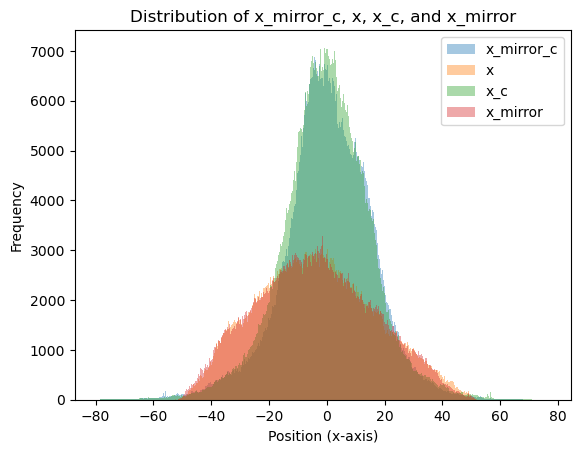

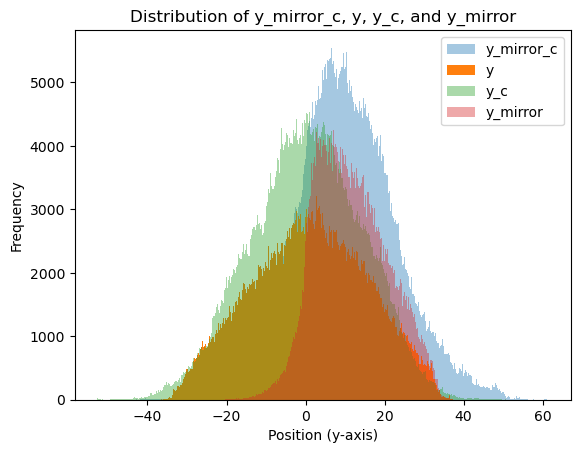

In [10]:
plt.hist(final_runs_df["x_mirror_c"], bins=500, alpha=0.4, label="x_mirror_c")
plt.hist(final_runs_df["x"], bins=500, alpha=0.4, label="x")
plt.hist(final_runs_df["x_c"], bins=500, alpha=0.4, label="x_c")
plt.hist(final_runs_df["x_mirror"], bins=500, alpha=0.4, label="x_mirror")
plt.title("Distribution of x_mirror_c, x, x_c, and x_mirror")
plt.xlabel("Position (x-axis)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist(final_runs_df["y_mirror_c"], bins=500, alpha=0.4, label="y_mirror_c")
plt.hist(final_runs_df["y"], bins=500, alpha=1.0, label="y")
plt.hist(final_runs_df["y_c"], bins=500, alpha=0.4, label="y_c")
plt.hist(final_runs_df["y_mirror"], bins=500, alpha=0.4, label="y_mirror")
plt.title("Distribution of y_mirror_c, y, y_c, and y_mirror")
plt.xlabel("Position (y-axis)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Defining Different Types of Tactical Runs:

## Overlapping Runs: 

In [ ]:
# def extract_ball_carrier_df(run_df, frames_df, players_df, frame_last_touch_team):
#     """
#     For a given run_df, extracts ball carrier positions for the same team
#     during the frames of the run.
#     Returns:
#         ball_carrier_df or None
#     """
#     match_id = run_df["match_id"].iloc[0]
#     period = run_df["period"].iloc[0]
#     team_role = run_df["team_role"].iloc[0]
#     frames = run_df["frameIdx"].values

#     carrier_rows = []

#     for f in frames:
#         key = (match_id, period, f)
#         last_touch_side = frame_last_touch_team.get(key)

#         if last_touch_side != team_role:
#             # Ball not possessed by same team
#             continue

#         # Get ball position
#         ball_row = frames_df[
#             (frames_df["match_id"] == match_id) &
#             (frames_df["period"] == period) &
#             (frames_df["frameIdx"] == f)
#         ]

#         if ball_row.empty:
#             continue

#         ball_x = ball_row["ball_x"].values[0]
#         ball_y = ball_row["ball_y"].values[0]

#         # Get team players
#         team_players = players_df[
#             (players_df["match_id"] == match_id) &
#             (players_df["period"] == period) &
#             (players_df["frameIdx"] == f) &
#             (players_df["side"] == team_role)
#         ]

#         if team_players.empty:
#             continue

#         team_players = team_players.copy()
#         team_players["dist_to_ball"] = np.linalg.norm(
#             team_players[["x", "y"]].values - np.array([[ball_x, ball_y]]), axis=1
#         )
#         carrier_row = team_players.loc[team_players["dist_to_ball"].idxmin()]
#         carrier_rows.append(carrier_row)

#     if carrier_rows:
#         ball_carrier_df = pd.DataFrame(carrier_rows)
#         return ball_carrier_df
#     else:
#         return None

def extract_ball_carrier_df_fast(run_df, players_with_ball_df):
    """
    Fast version of extract_ball_carrier_df.
    """
    match_id = run_df["match_id"].iloc[0]
    period = run_df["period"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    frames = run_df["frameIdx"].unique()

    # Slice relevant frames for this run
    run_players = players_with_ball_df[
        (players_with_ball_df["match_id"] == match_id) &
        (players_with_ball_df["period"] == period) &
        (players_with_ball_df["frameIdx"].isin(frames))
    ]

    # Keep only teammates
    teammates = run_players[
        run_players["side"] == team_role
    ].copy()

    if teammates.empty:
        return None

    # Compute distance to ball
    teammates["dist_to_ball"] = np.linalg.norm(
        teammates[["x", "y"]].values - teammates[["ball_x", "ball_y"]].values,
        axis=1
    )

    # Find closest player in each frame
    idx_min_dist = teammates.groupby("frameIdx")["dist_to_ball"].idxmin()

    ball_carrier_df = teammates.loc[idx_min_dist]

    if ball_carrier_df.empty:
        return None
    else:
        return ball_carrier_df
    
# Check later, should it be closest to ball or should there be a minimum distance?

# def is_overlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0):
#     """
#     Heuristic: checks if the run overlaps the ball carrier.
#     Returns True if overlap is detected.
#     """
#     if ball_carrier_df is None:
#         return False

#     # Check first and last frames
#     f_start = run_df["frameIdx"].iloc[0]
#     f_end = run_df["frameIdx"].iloc[-1]

#     runner_start = run_df.iloc[0][["x", "y"]].values
#     runner_end = run_df.iloc[-1][["x", "y"]].values

#     carrier_start = ball_carrier_df.loc[
#         ball_carrier_df["frameIdx"] == f_start,
#         ["x", "y"]
#     ]

#     carrier_end = ball_carrier_df.loc[
#         ball_carrier_df["frameIdx"] == f_end,
#         ["x", "y"]
#     ]

#     if carrier_start.empty or carrier_end.empty:
#         return False

#     carrier_start = carrier_start.iloc[0].values
#     carrier_end = carrier_end.iloc[0].values

#     # Compute lateral offset (y-direction)
#     delta_start_y = runner_start[1] - carrier_start[1]
#     delta_end_y = runner_end[1] - carrier_end[1]

#     # Check if runner switched sides outside ball carrier
#     overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)
    
#     # Check lateral distance threshold
#     lateral_movement = abs(delta_end_y - delta_start_y)

#     # Optional: ensure overlap actually moves forward enough
#     forward_distance = runner_end[0] - runner_start[0]

#     return (
#         overlap_side_change and
#         lateral_movement > 2.0 and
#         forward_distance > min_pass_distance
#     )

def is_overlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0):
    """
    Checks if a run overlaps the ball carrier.
    Skips runs if the ball carrier changes during the run.
    """
    if ball_carrier_df is None:
        return False

    # Check how many unique carriers there were during this run
    unique_carriers = ball_carrier_df["playerId"].nunique()
    # Can look at subRuns later, but for now we assume one carrier per run
    if unique_carriers > 1:
        # Carrier changed mid-run; skip for safety
        return False

    # Proceed as before
    f_start = run_df["frameIdx"].iloc[0]
    f_end = run_df["frameIdx"].iloc[-1]

    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    carrier_start_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_start
    ]

    carrier_end_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_end
    ]

    if carrier_start_row.empty or carrier_end_row.empty:
        return False

    carrier_start = carrier_start_row.iloc[0][["x", "y"]].values
    carrier_end = carrier_end_row.iloc[0][["x", "y"]].values

    # Compute lateral offset (y-direction)
    delta_start_y = runner_start[1] - carrier_start[1]
    delta_end_y = runner_end[1] - carrier_end[1]

    # Check if runner switched sides outside the carrier
    overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

    # Check lateral distance threshold
    lateral_movement = abs(delta_end_y - delta_start_y)

    # Ensure overlap moves forward enough
    forward_distance = runner_end[0] - runner_start[0]

    return (
        overlap_side_change and
        lateral_movement > 2.0 and
        forward_distance > min_pass_distance
    )

# Underlapping Run

In [ ]:
# def is_underlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0):
#     """
#     Heuristic: detects underlapping runs where the runner cuts inside
#     relative to the ball carrier.
#     """
#     if ball_carrier_df is None:
#         return False

#     # Check first and last frames
#     f_start = run_df["frameIdx"].iloc[0]
#     f_end = run_df["frameIdx"].iloc[-1]

#     runner_start = run_df.iloc[0][["x", "y"]].values
#     runner_end = run_df.iloc[-1][["x", "y"]].values

#     carrier_start = ball_carrier_df.loc[
#         ball_carrier_df["frameIdx"] == f_start,
#         ["x", "y"]
#     ]

#     carrier_end = ball_carrier_df.loc[
#         ball_carrier_df["frameIdx"] == f_end,
#         ["x", "y"]
#     ]

#     if carrier_start.empty or carrier_end.empty:
#         return False

#     carrier_start = carrier_start.iloc[0].values
#     carrier_end = carrier_end.iloc[0].values

#     # Compute lateral offsets (y-difference)
#     delta_start_y = runner_start[1] - carrier_start[1]
#     delta_end_y = runner_end[1] - carrier_end[1]

#     overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

#     lateral_distance_start = abs(delta_start_y)
#     lateral_distance_end = abs(delta_end_y)

#     lateral_movement = lateral_distance_start - lateral_distance_end

#     forward_distance = runner_end[0] - runner_start[0]

#     # For underlap:
#     # - sign change
#     # - lateral distance reduced (runner cuts inside)
#     # - forward enough
#     return (
#         overlap_side_change
#         and lateral_movement > 1.0
#         and forward_distance > min_pass_distance
#     )

def is_underlapping_run(run_df, ball_carrier_df, min_pass_distance=5.0):
    """
    Heuristic: detects underlapping runs where the runner cuts inside
    relative to the ball carrier.

    Returns True only if the ball carrier remains constant during the run.
    """
    if ball_carrier_df is None:
        return False

    # Check how many unique carriers there were during this run
    unique_carriers = ball_carrier_df["playerId"].nunique()
    if unique_carriers > 1:
        # Carrier changed mid-run; skip for safety
        return False

    # Proceed as before
    f_start = run_df["frameIdx"].iloc[0]
    f_end = run_df["frameIdx"].iloc[-1]

    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    carrier_start_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_start
    ]

    carrier_end_row = ball_carrier_df.loc[
        ball_carrier_df["frameIdx"] == f_end
    ]

    if carrier_start_row.empty or carrier_end_row.empty:
        return False

    carrier_start = carrier_start_row.iloc[0][["x", "y"]].values
    carrier_end = carrier_end_row.iloc[0][["x", "y"]].values

    # Compute lateral offsets (y-difference)
    delta_start_y = runner_start[1] - carrier_start[1]
    delta_end_y = runner_end[1] - carrier_end[1]

    overlap_side_change = np.sign(delta_start_y) != np.sign(delta_end_y)

    lateral_distance_start = abs(delta_start_y)
    lateral_distance_end = abs(delta_end_y)

    lateral_movement = lateral_distance_start - lateral_distance_end

    forward_distance = runner_end[0] - runner_start[0]

    # For underlap:
    # - sign change
    # - lateral distance reduced (runner cuts inside)
    # - forward enough
    return (
        overlap_side_change
        and lateral_movement > 1.0
        and forward_distance > min_pass_distance
    )

# Diagonal Run

In [ ]:
def is_diagonal_run(run_df, min_length=5.0, angle_min=20, angle_max=70):
    """
    Heuristic to detect diagonal runs.

    - Checks total length
    - Checks that the angle lies within a diagonal corridor

    Returns True if diagonal.
    """
    # Start and end positions
    runner_start = run_df.iloc[0][["x", "y"]].values
    runner_end = run_df.iloc[-1][["x", "y"]].values

    delta_x = runner_end[0] - runner_start[0]
    delta_y = runner_end[1] - runner_start[1]

    # Total run distance
    total_distance = np.linalg.norm([delta_x, delta_y])
    if total_distance < min_length:
        return False

    # Compute angle in degrees
    angle_deg = np.degrees(np.arctan2(delta_y, delta_x))

    abs_angle = abs(angle_deg)

    # Check if angle is in diagonal corridor
    return angle_min <= abs_angle <= angle_max

In [ ]:
# Define grid
x_edges = np.linspace(-52.5, 52.5, 4)   # splits pitch length into thirds
y_edges = np.linspace(-34, 34, 4)       # splits width into thirds

def get_zone(x, y, x_edges, y_edges):
    x_bin = np.digitize([x], x_edges)[0] - 1
    y_bin = np.digitize([y], y_edges)[0] - 1
    x_bin = min(max(x_bin, 0), len(x_edges)-2)
    y_bin = min(max(y_bin, 0), len(y_edges)-2)
    zone_idx = y_bin * (len(x_edges)-1) + x_bin + 1
    return zone_idx

# Build players_with_ball_df ONCE for all runs
players_with_ball_df = players_df.merge(
    frames_df[["match_id", "period", "frameIdx", "ball_x", "ball_y", "lastTouch_team"]],
    on=["match_id", "period", "frameIdx"],
    how="left",
    suffixes=("", "_ball")
)

zone_records = []

for run_id, run_df in final_runs_df.groupby("run_id"):

    # Mirrored & centered positions
    start_x_mirror_c = run_df["x_mirror_c"].iloc[0]
    start_y_mirror_c = run_df["y_mirror_c"].iloc[0]

    end_x_mirror_c = run_df["x_mirror_c"].iloc[-1]
    end_y_mirror_c = run_df["y_mirror_c"].iloc[-1]

    coords = run_df[["x", "y"]].values

    if coords.shape[0] < 2:
        run_length = 0.0
    else: 
        deltas = np.diff(coords, axis=0)
        segment_lengths = np.linalg.norm(deltas, axis=1)
        run_length = np.sum(segment_lengths)

    mean_speed = run_df["speed"].mean()
    max_speed = run_df["speed"].max()

    dx = end_x_mirror_c - start_x_mirror_c
    dy = end_y_mirror_c - start_y_mirror_c

    run_angle_rad = np.arctan2(dy, dx)
    run_angle_deg = np.degrees(run_angle_rad)

    run_forward = dx > 0  # True if run is forward (right side of pitch)
    
    start_zone = get_zone(start_x_mirror_c, start_y_mirror_c, x_edges, y_edges)
    end_zone = get_zone(end_x_mirror_c, end_y_mirror_c, x_edges, y_edges)

    # Absolute pitch positions
    start_x_abs = run_df["x"].iloc[0]
    start_y_abs = run_df["y"].iloc[0]

    end_x_abs = run_df["x"].iloc[-1]
    end_y_abs = run_df["y"].iloc[-1]

    start_zone_abs = get_zone(start_x_abs, start_y_abs, x_edges, y_edges)
    end_zone_abs = get_zone(end_x_abs, end_y_abs, x_edges, y_edges)

    phase_of_play = run_df["phase_of_play"].iloc[0]
    in_possession = run_df["in_possession"].iloc[0]
    team_role = run_df["team_role"].iloc[0]
    position = run_df["position"].iloc[0]

    # Extract ball carrier df
    ball_carrier_df = extract_ball_carrier_df_fast(
        run_df, players_with_ball_df
    )
    
    # Check overlapping run
    overlapping = is_overlapping_run(run_df, ball_carrier_df)
    underlapping = is_underlapping_run(run_df, ball_carrier_df)
    is_diag = is_diagonal_run(run_df)

    zone_records.append({
        "run_id": run_id,
        "start_zone": start_zone,
        "end_zone": end_zone,
        "start_zone_absolute": start_zone_abs,
        "end_zone_absolute": end_zone_abs,
        "phase_of_play": phase_of_play,
        "in_possession": in_possession,
        "team_role": team_role,
        "position": position,
        "run_length_m": run_length,
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "run_angle_deg": run_angle_deg,
        "run_forward": run_forward,
        "tactical_overlap": overlapping,
        "tactical_underlap": underlapping,
        "tactical_diagonal": is_diag
    })

zones_df = pd.DataFrame(zone_records)
print(zones_df.head())

KeyboardInterrupt: 

In [ ]:
# Equation (5): Bézier basis function
def bernstein_poly(p, P, t):
    return comb(P - 1, p) * (t**p) * ((1 - t)**(P - 1 - p))

# Equation (7): Design matrix for Bézier fitting
def bezier_design_matrix(num_points, num_control_points):
    t_vals = np.linspace(0, 1, num_points)
    X = np.stack([bernstein_poly(p, num_control_points, t_vals) for p in range(num_control_points)], axis=1)
    return X  # shape: [num_points, num_control_points]

# Equation (6): Fit Bézier curve via least squares
def fit_bezier_curve(coords, num_control_points):
    """
    coords: shape [N, 2] — sequence of (x, y) points
    returns: control_points [P, 2]
    """
    N = coords.shape[0]
    X = bezier_design_matrix(N, num_control_points)  # shape [N, P]
    
    # Solve least squares for x and y separately
    theta_x, _, _, _ = np.linalg.lstsq(X, coords[:, 0], rcond=None)
    theta_y, _, _, _ = np.linalg.lstsq(X, coords[:, 1], rcond=None)
    
    control_points = np.stack([theta_x, theta_y], axis=1)  # shape: [P, 2]
    return control_points

# Equation (4): Evaluate Bézier curve at t using control points θ
def evaluate_bezier_curve(control_points, num_points=50):
    """
    Returns sampled points along the Bézier curve.
    """
    P = control_points.shape[0]
    X = bezier_design_matrix(num_points, P)  # shape [num_points, P]
    curve = X @ control_points  # shape: [num_points, 2]
    return curve

In [ ]:
def resample_coords(coords, num_points=50):
    from scipy.interpolate import interp1d
    if len(coords) < 2:
        return np.tile(coords[0], (num_points, 1))  # Edge case
    distances = np.cumsum(np.linalg.norm(np.diff(coords, axis=0), axis=1))
    distances = np.insert(distances, 0, 0.0)
    total_length = distances[-1]
    if total_length == 0:
        return np.tile(coords[0], (num_points, 1))
    normalized_dist = distances / total_length
    interp_func = interp1d(normalized_dist, coords, axis=0, kind='linear')
    uniform_dist = np.linspace(0, 1, num_points)
    return interp_func(uniform_dist)

def compute_l1_distance(traj, bezier_curve):
    """
    traj, bezier_curve: both of shape [num_points, 2]
    """
    return np.mean(np.abs(traj - bezier_curve))  # L1 averaged over all points and dimensions

In [ ]:
max_iterations = 1 # only 1 iteration for now (for debugging)
tolerance = 1e-3  # Minimum improvement in objective to continue
num_points = 50
num_control_points = 4
k_clusters = 70

# Initialize cluster centers (Bézier curves)
random.seed(42)
initial_centroids = random.sample(adjusted_runs_list, k_clusters)
cluster_control_points = []

for run in initial_centroids:
    coords = run[["x_mirror_c", "y_mirror_c"]].values
    control_pts = fit_bezier_curve(coords, num_control_points)
    cluster_control_points.append(control_pts)

cluster_control_points = np.array(cluster_control_points)
previous_objective = float('inf')

for it in range(max_iterations):
    # Assignment step
    assignments = []
    objective_distances = []

    for run_id, run_df in final_runs_df.groupby("run_id"):
        coords = run_df[["x_mirror_c", "y_mirror_c"]].values
        # resampled_coords = resample_coords(coords, num_points=num_points)

        resampled_coords = resample_coords(coords, num_points=num_points)
        if resampled_coords is None:
            continue  # skip bad run

        min_dist = float("inf")
        assigned_cluster = -1

        for cluster_idx, control_pts in enumerate(cluster_control_points):
            bezier_curve = evaluate_bezier_curve(control_pts, num_points=num_points)
            dist = compute_l1_distance(resampled_coords, bezier_curve)
            if dist < min_dist:
                min_dist = dist
                assigned_cluster = cluster_idx

        # assignments.append(assigned_cluster)

            # Save metadata + cluster assignment
        assignments.append({
            "run_id": run_id,
            "assigned_cluster": assigned_cluster,
            "min_distance": min_dist,
            "playerId": run_df["playerId"].iloc[0],
            "player_name": run_df["player_name"].iloc[0],
            "position": run_df["position"].iloc[0],
            "team_role": run_df["team_role"].iloc[0],
            "match_id": run_df["match_id"].iloc[0],
        })

        assignments_df = pd.DataFrame(assignments)

        #print(assignments_df.head())

        objective_distances.append(min_dist)

    objective = np.mean(objective_distances)
    print(f"Iteration {it}: Mean objective = {objective:.4f}")

    # Check for convergence
    improvement = previous_objective - objective
    if improvement < tolerance:
        print(f"Converged (Δ={improvement:.6f}) at iteration {it}")
        break
    previous_objective = objective

    # Update step
    new_cluster_control_points = []

    for cluster_idx in range(k_clusters):
        #assigned_indices = [i for i, a in enumerate(assignments) if a == cluster_idx]
        assigned_indices = [i for i, a in enumerate(assignments) if a["assigned_cluster"] == cluster_idx]
        if not assigned_indices:
            new_cluster_control_points.append(cluster_control_points[cluster_idx])
            continue

        cluster_coords = []
        for idx in assigned_indices:
            run_id = assignments_df.loc[idx, "run_id"]
            #run_df = all_runs_df[all_runs_df["run_id"] == run_id]
            run_df = final_runs_df[final_runs_df["run_id"] == run_id]

            coords = run_df[["x_mirror_c", "y_mirror_c"]].values
            resampled = resample_coords(coords, num_points=num_points)
            # cluster_coords.append(resampled)
            if resampled is not None:
                cluster_coords.append(resampled)

        cluster_coords = np.stack(cluster_coords, axis=0)
        mean_coords = np.mean(cluster_coords, axis=0)
        new_control_pts = fit_bezier_curve(mean_coords, num_control_points)
        new_cluster_control_points.append(new_control_pts)

    cluster_control_points = np.array(new_cluster_control_points)



Iteration 0: Mean objective = 3.1526


In [ ]:
# Build assignments DataFrame
assignments_df = pd.DataFrame(assignments)

assignments_zones = assignments_df.merge(
    zones_df,
    on="run_id",
    how="left"
)

# Drop duplicates
assignments_zones.drop(columns=[
    "position_y",
    "team_role_y"
], inplace=True, errors="ignore")

# Rename x columns back to plain names
assignments_zones.rename(columns={
    "position_x": "position",
    "team_role_x": "team_role",
}, inplace=True)

# Count number of runs per position per cluster
position_detail_counts = (
    assignments_zones
    .groupby(["assigned_cluster", "position"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)

position_pivot = (
    position_detail_counts
    .pivot_table(index="assigned_cluster",
                 columns="position",
                 values="num_runs",
                 fill_value=0)
    .reset_index()
)


# Filtering for specific positions: 

filter only LB runs:

In [18]:
lb_runs = assignments_zones[assignments_zones["position"] == "LB"]

print(lb_runs.head())

      run_id  assigned_cluster  min_distance  \
1170    1170                65      2.074770   
1171    1171                46      4.640845   
1172    1172                 4      4.297023   
1173    1173                 4      6.598929   
1174    1174                 9      4.500338   

                                  playerId   player_name position team_role  \
1170  3d2d548f-5118-4af3-b1f1-fa9d7c5fc64f  O. Zinchenko       LB      away   
1171  3d2d548f-5118-4af3-b1f1-fa9d7c5fc64f  O. Zinchenko       LB      away   
1172  3d2d548f-5118-4af3-b1f1-fa9d7c5fc64f  O. Zinchenko       LB      away   
1173  3d2d548f-5118-4af3-b1f1-fa9d7c5fc64f  O. Zinchenko       LB      away   
1174  3d2d548f-5118-4af3-b1f1-fa9d7c5fc64f  O. Zinchenko       LB      away   

                    match_id  start_zone  end_zone  start_zone_absolute  \
1170  tracking_g2292810.json           5         5                    5   
1171  tracking_g2292810.json           5         4                    5   
1172  track

If you want only clusters containing LB runs

In [19]:
lb_clusters = lb_runs["assigned_cluster"].unique()
print("Clusters with LB runs:", lb_clusters)

Clusters with LB runs: [65 46  4  9 57  8  1 43 54  0 14 15  5 44  6 17 66 62 32 58 41 55 12 64
 26 69 22 34 23 27  3 49 53 40 52 28 67 30 51 10 19 50 47 45 59 37 18 48
 42 61 56 39 13 11 16 63 29 68 31 35]


In [20]:
# Keep first row of each run
runs_meta_df = final_runs_df.groupby("run_id", as_index=False).first()

# Merge metadata into assignments
merged_df = assignments_df.merge(
    runs_meta_df,
    on="run_id",
    how="left"
)

# Clean up columns
merged_df.drop(columns=[
    "position_y",
    "player_name_y",
    "team_role_y",
    "match_id_y",
    "playerId_y",
], inplace=True, errors="ignore")

merged_df.rename(columns={
    "player_name_x": "player_name",
    "position_x": "position",
    "team_role_x": "team_role",
    "match_id_x": "match_id",
    "playerId_x": "playerId",
}, inplace=True)

#print("merged_df columns:", merged_df.columns)

# Group and count
position_counts = (
    merged_df
    .groupby(["assigned_cluster", "position"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)

#print(position_counts.head(100))

In [21]:
unique_positions = merged_df["position"].dropna().unique()
print("Unique positions found:", unique_positions)
print("Total unique positions:", len(unique_positions))

Unique positions found: ['LW' 'RCB' 'CDM' 'GK' 'LCB' 'LB' 'CAM' 'RW' 'RDM' 'LDM' 'CF' 'RCM' 'RB'
 'LCM' 'ST' 'SUB']
Total unique positions: 16


In [22]:
# Mapping of fine-grained positions → high-level buckets
position_bucket_map = {
    "GK": "sub",       # treat as non-field player for running
    "SUB": "sub",
    
    # Defenders
    "CB": "defender",
    "RCB": "defender",
    "LCB": "defender",
    "RB": "defender",
    "LB": "defender",
    "RWB": "defender",
    "LWB": "defender",
    
    # Midfielders
    "CDM": "midfielder",
    "RDM": "midfielder",
    "LDM": "midfielder",
    "CM": "midfielder",
    "RCM": "midfielder",
    "LCM": "midfielder",
    "CAM": "midfielder",
    "RM": "midfielder",
    "LM": "midfielder",
    
    # Attackers
    "LW": "attacker",
    "RW": "attacker",
    "ST": "attacker",
    "CF": "attacker",
    "RF": "attacker",
    "LF": "attacker",
}

# Map positions to buckets
merged_df["position_bucket"] = merged_df["position"].map(
    lambda pos: position_bucket_map.get(pos, "unknown")
)

print(merged_df[["assigned_cluster", "position", "position_bucket"]].head(1000))


     assigned_cluster position position_bucket
0                  53       LW        attacker
1                  65       LW        attacker
2                  53       LW        attacker
3                   2       LW        attacker
4                   2       LW        attacker
..                ...      ...             ...
995                28      LCB        defender
996                34      LCB        defender
997                34      LCB        defender
998                34      LCB        defender
999                34      LCB        defender

[1000 rows x 3 columns]


In [23]:
bucket_counts = (
    merged_df
    .groupby(["assigned_cluster", "position_bucket"])
    .size()
    .reset_index(name="num_runs")
    .sort_values(["assigned_cluster", "num_runs"], ascending=[True, False])
)

print(bucket_counts.head(20))

bucket_pivot = (
    bucket_counts
    .pivot_table(index="assigned_cluster", 
                 columns="position_bucket", 
                 values="num_runs", 
                 fill_value=0)
    .reset_index()
)

print(bucket_pivot.head())

    assigned_cluster position_bucket  num_runs
0                  0        defender        71
1                  0      midfielder        13
2                  0             sub        11
5                  1      midfielder       192
4                  1        defender        50
3                  1        attacker        30
6                  1             sub        14
7                  2        attacker        75
9                  2             sub        36
8                  2      midfielder         9
11                 3        defender        63
12                 3      midfielder        10
10                 3        attacker         4
13                 3             sub         2
15                 4        defender        48
16                 4      midfielder        20
14                 4        attacker        15
19                 5      midfielder        74
17                 5        attacker        31
18                 5        defender        14
position_buck

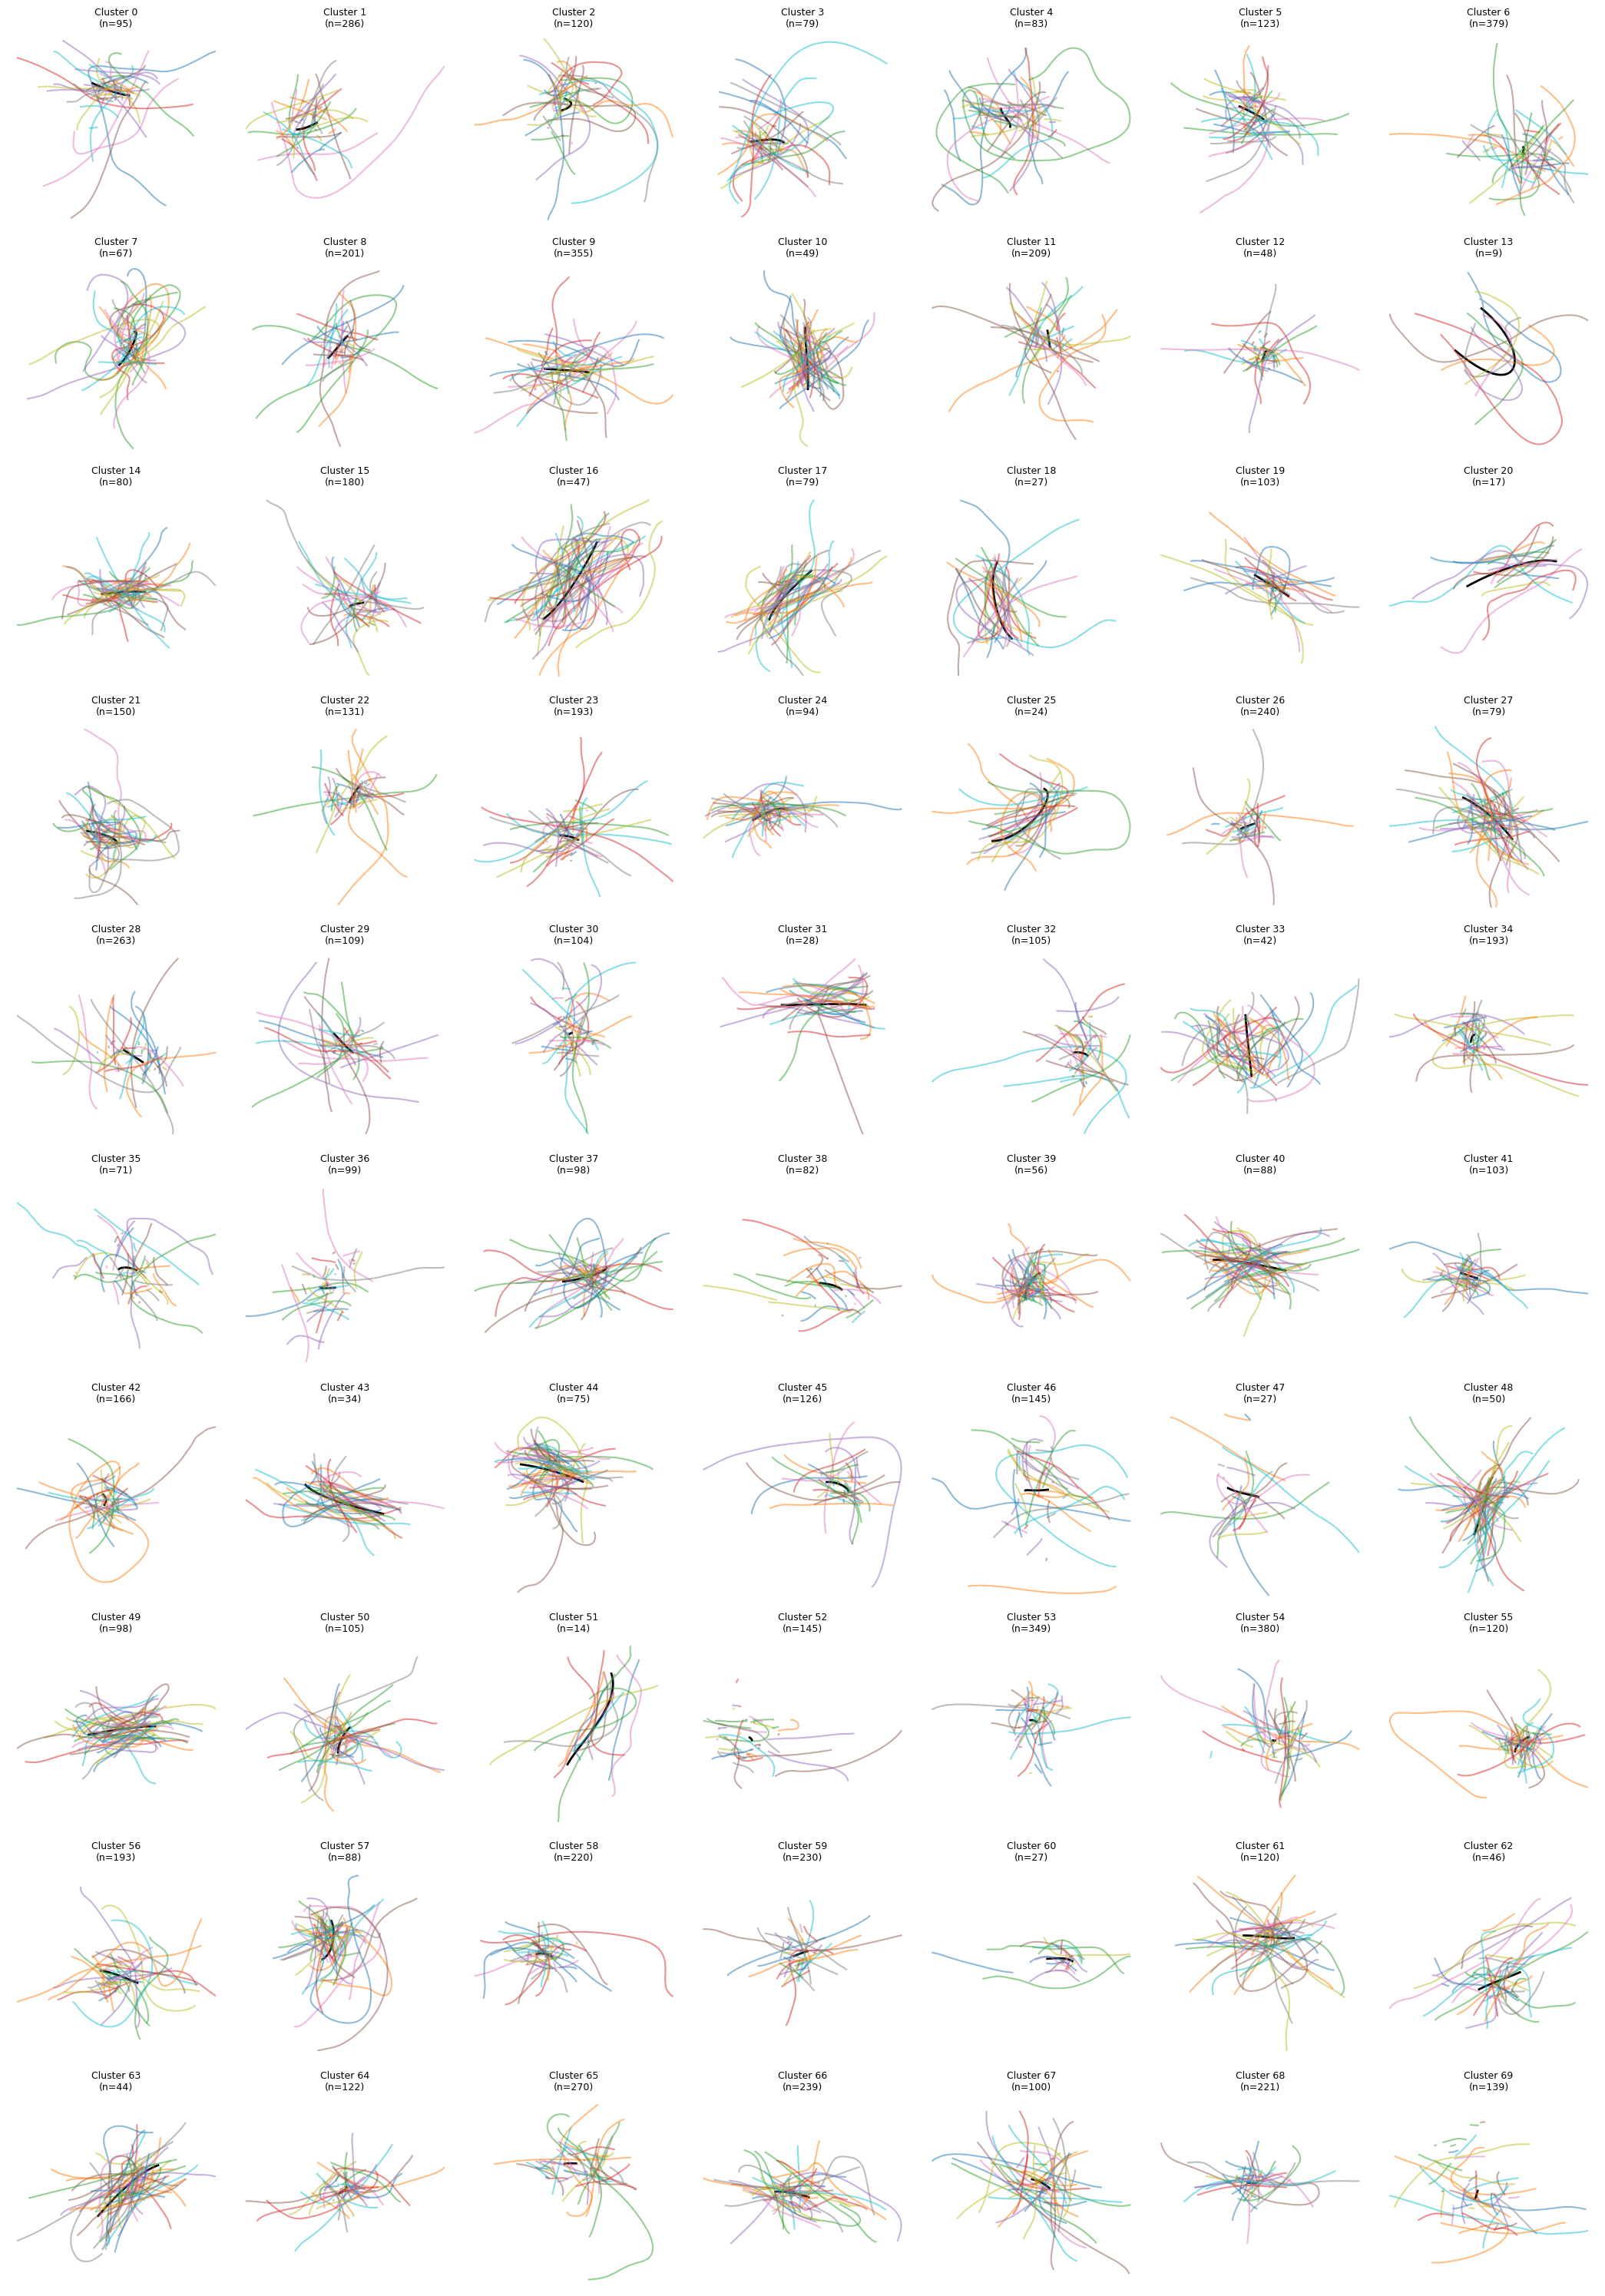

In [24]:
def plot_all_clusters_grid(cluster_control_points, final_runs_df, assignments, samples_per_cluster=50, rows=10, cols=7):
    import matplotlib.pyplot as plt
    import random

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    # Convert assignments to a DataFrame for easy filtering
    assignments_df = pd.DataFrame(assignments)

    for cluster_idx in range(len(cluster_control_points)):
        ax = axes[cluster_idx]

        # Plot Bézier center curve
        bezier_curve = evaluate_bezier_curve(cluster_control_points[cluster_idx], num_points=50)
        ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], 'k-', linewidth=2, label="Cluster")

        # Find runs assigned to this cluster
        run_ids_in_cluster = assignments_df.loc[
            assignments_df["assigned_cluster"] == cluster_idx, "run_id"
        ].tolist()

        # Randomly sample some of them
        if run_ids_in_cluster:
            sampled_run_ids = random.sample(
                run_ids_in_cluster,
                min(samples_per_cluster, len(run_ids_in_cluster))
            )

            for run_id in sampled_run_ids:
                run_df = final_runs_df[final_runs_df["run_id"] == run_id]
                coords = run_df[["x_mirror_c", "y_mirror_c"]].values
                ax.plot(coords[:, 0], coords[:, 1], alpha=0.5)

        ax.set_title(f"Cluster {cluster_idx}\n(n={len(run_ids_in_cluster)})", fontsize=9)
        ax.axis("equal")
        ax.axis("off")

    # Hide any unused subplots
    for i in range(len(cluster_control_points), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

plot_all_clusters_grid(cluster_control_points, final_runs_df, assignments)

In [25]:
def draw_pitch(ax, pitch_length=105, pitch_width=68):
    """
    Draws a football pitch centered around (0, 0) on the given matplotlib axis.
    """
    half_length = pitch_length / 2
    half_width = pitch_width / 2

    # Outer boundary & centre line
    ax.plot([-half_length, -half_length, half_length, half_length, -half_length],
            [-half_width, half_width, half_width, -half_width, -half_width], color="black")
    ax.plot([0, 0], [-half_width, half_width], color="black")

    # Left penalty area
    ax.plot([-half_length + 16.5, -half_length + 16.5], [-13.84, 13.84], color="black")
    ax.plot([-half_length, -half_length + 16.5], [-13.84, -13.84], color="black")
    ax.plot([-half_length, -half_length + 16.5], [13.84, 13.84], color="black")

    # Right penalty area
    ax.plot([half_length - 16.5, half_length - 16.5], [-13.84, 13.84], color="black")
    ax.plot([half_length, half_length - 16.5], [-13.84, -13.84], color="black")
    ax.plot([half_length, half_length - 16.5], [13.84, 13.84], color="black")

    # Center circle
    circle = plt.Circle((0, 0), 9.15, color="black", fill=False)
    ax.add_patch(circle)

    ax.set_xlim(-half_length, half_length)
    ax.set_ylim(-half_width, half_width)
    ax.set_aspect("equal")
    ax.axis("off")



In [26]:
def plot_all_cluster_trajectories_on_pitch(
    final_runs_df,
    assignments_zones,
    cluster_control_points,
    bucket_pivot,
    num_control_points=4,
    max_runs_per_cluster=30,
    plot_absolute_positions=True,
    start_zones=None,
    end_zones=None,
    phases_of_play=None,
    positions=None,
    use_absolute_zones=False,
    start_zones_absolute=None,
    end_zones_absolute=None,
    run_angle_range = None, #tuple of (min_angle, max_angle) in degrees
    run_forward = None, #bool, whether to filter for forward runs only
    run_length_range = None, #tuple of (min_length, max_length) in meters
    mean_speed_range = None, #tuple of (min_speed, max_speed) in meters per second
    max_speed_range = None #tuple of (min_speed, max_speed)
):
    import matplotlib.pyplot as plt
    import random

    num_clusters = len(cluster_control_points)
    fig, axes = plt.subplots(7, 10, figsize=(30, 20))
    axes = axes.flatten()

    # --- FILTERING ---
    filtered_assignments = assignments_zones.copy()

    if start_zones is not None and not use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["start_zone"].isin(start_zones)
        ]

    if end_zones is not None and not use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["end_zone"].isin(end_zones)
        ]

    if start_zones_absolute is not None and use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["start_zone_absolute"].isin(start_zones_absolute)
        ]

    if end_zones_absolute is not None and use_absolute_zones:
        filtered_assignments = filtered_assignments[
            filtered_assignments["end_zone_absolute"].isin(end_zones_absolute)
        ]

    if phases_of_play is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["phase_of_play"].isin(phases_of_play)
        ]

    if positions is not None:
        filtered_assignments = filtered_assignments[
            filtered_assignments["position"].isin(positions)
        ]

    if run_angle_range is not None:
        min_angle, max_angle = run_angle_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["run_angle_deg"] >= min_angle) &
            (filtered_assignments["run_angle_deg"] <= max_angle)]
    
    if run_forward is not None: 
        filtered_assignments = filtered_assignments[
            filtered_assignments["run_forward"] == run_forward]
    
    if run_length_range is not None:
        min_len, max_len = run_length_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["run_length_m"] >= min_len) &
            (filtered_assignments["run_length_m"] <= max_len)
        ]

    if mean_speed_range is not None:
        min_speed, max_speed = mean_speed_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["mean_speed"] >= min_speed) &
            (filtered_assignments["mean_speed"] <= max_speed)
        ]

    if max_speed_range is not None:
        min_speed, max_speed = max_speed_range
        filtered_assignments = filtered_assignments[
            (filtered_assignments["max_speed"] >= min_speed) &
            (filtered_assignments["max_speed"] <= max_speed)
        ]

    filtered_run_ids = filtered_assignments["run_id"].unique()

    bucket_pivot = bucket_pivot.set_index("assigned_cluster")

    for cluster_idx in range(num_clusters):
        ax = axes[cluster_idx]
        draw_pitch(ax)

        cluster_run_ids = assignments_zones.loc[
            assignments_zones["assigned_cluster"] == cluster_idx, "run_id"
        ].tolist()

        cluster_run_ids = [
            rid for rid in cluster_run_ids if rid in filtered_run_ids
        ]

        if len(cluster_run_ids) > max_runs_per_cluster:
            cluster_run_ids = random.sample(cluster_run_ids, max_runs_per_cluster)

        for run_id in cluster_run_ids:
            run_df = final_runs_df[final_runs_df["run_id"] == run_id]

            coords = run_df[["x_mirror_c", "y_mirror_c"]].values
            if coords.shape[0] < 2:
                continue

            resampled = resample_coords(coords, num_points=50)
            control_pts = fit_bezier_curve(resampled, num_control_points)

            if plot_absolute_positions:
                start_pos = run_df[["x", "y"]].values[0]
                shifted_ctrl_pts = control_pts - control_pts[0] + start_pos
                bezier_curve = evaluate_bezier_curve(
                    shifted_ctrl_pts, num_points=50
                )
            else:
                bezier_curve = evaluate_bezier_curve(
                    control_pts, num_points=50
                )

            ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], alpha=0.2, color="blue")

        if cluster_idx in bucket_pivot.index:
            row = bucket_pivot.loc[cluster_idx]
            text_lines = []
            for bucket in ["attacker", "midfielder", "defender", "sub", "unknown"]:
                if bucket in row and row[bucket] > 0:
                    text_lines.append(f"{bucket}: {int(row[bucket])}")
            text = "\n".join(text_lines)
            ax.text(
                0.5, 1.2, text,
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
            )

        ax.set_title(f"Cluster {cluster_idx}", fontsize=8)

    for i in range(num_clusters, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.suptitle("All Bézier Run Trajectories per Cluster (On-Pitch View)", fontsize=16, y=1.02)
    plt.show()

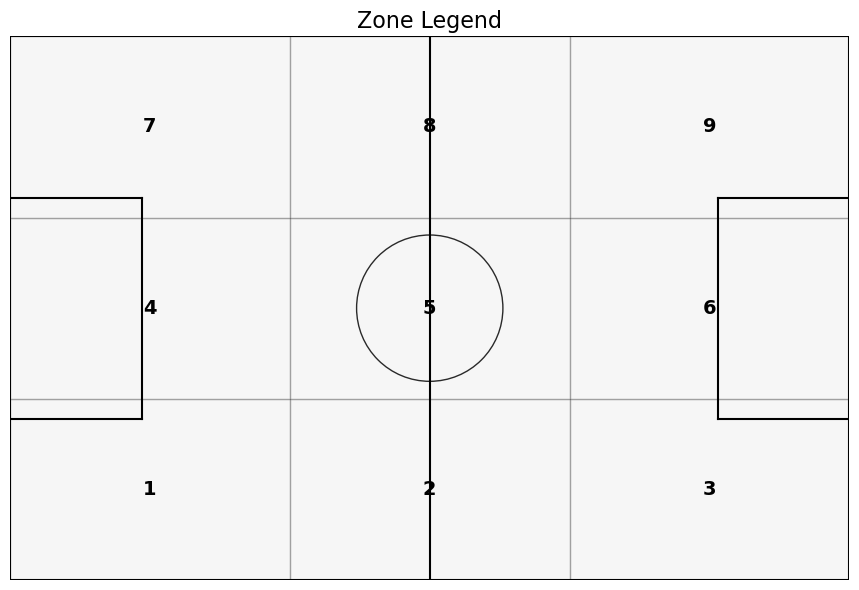

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Define edges matching your pitch grid
x_edges = np.linspace(-52.5, 52.5, 4)
y_edges = np.linspace(-34, 34, 4)

fig, ax = plt.subplots(figsize=(10, 6))

# Draw pitch outline
draw_pitch(ax)

zone_idx = 1

# Draw zone rectangles and labels
for y_bin in range(3):
    for x_bin in range(3):
        x_left = x_edges[x_bin]
        x_right = x_edges[x_bin + 1]
        y_bottom = y_edges[y_bin]
        y_top = y_edges[y_bin + 1]

        width = x_right - x_left
        height = y_top - y_bottom

        rect = patches.Rectangle(
            (x_left, y_bottom),
            width,
            height,
            linewidth=1,
            edgecolor='black',
            facecolor='lightgrey',
            alpha=0.2
        )
        ax.add_patch(rect)

        # Label in center
        x_center = (x_left + x_right) / 2
        y_center = (y_bottom + y_top) / 2

        ax.text(
            x_center, y_center,
            str(zone_idx),
            ha='center',
            va='center',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

        zone_idx += 1

ax.set_title("Zone Legend", fontsize=16)
plt.tight_layout()
plt.show()

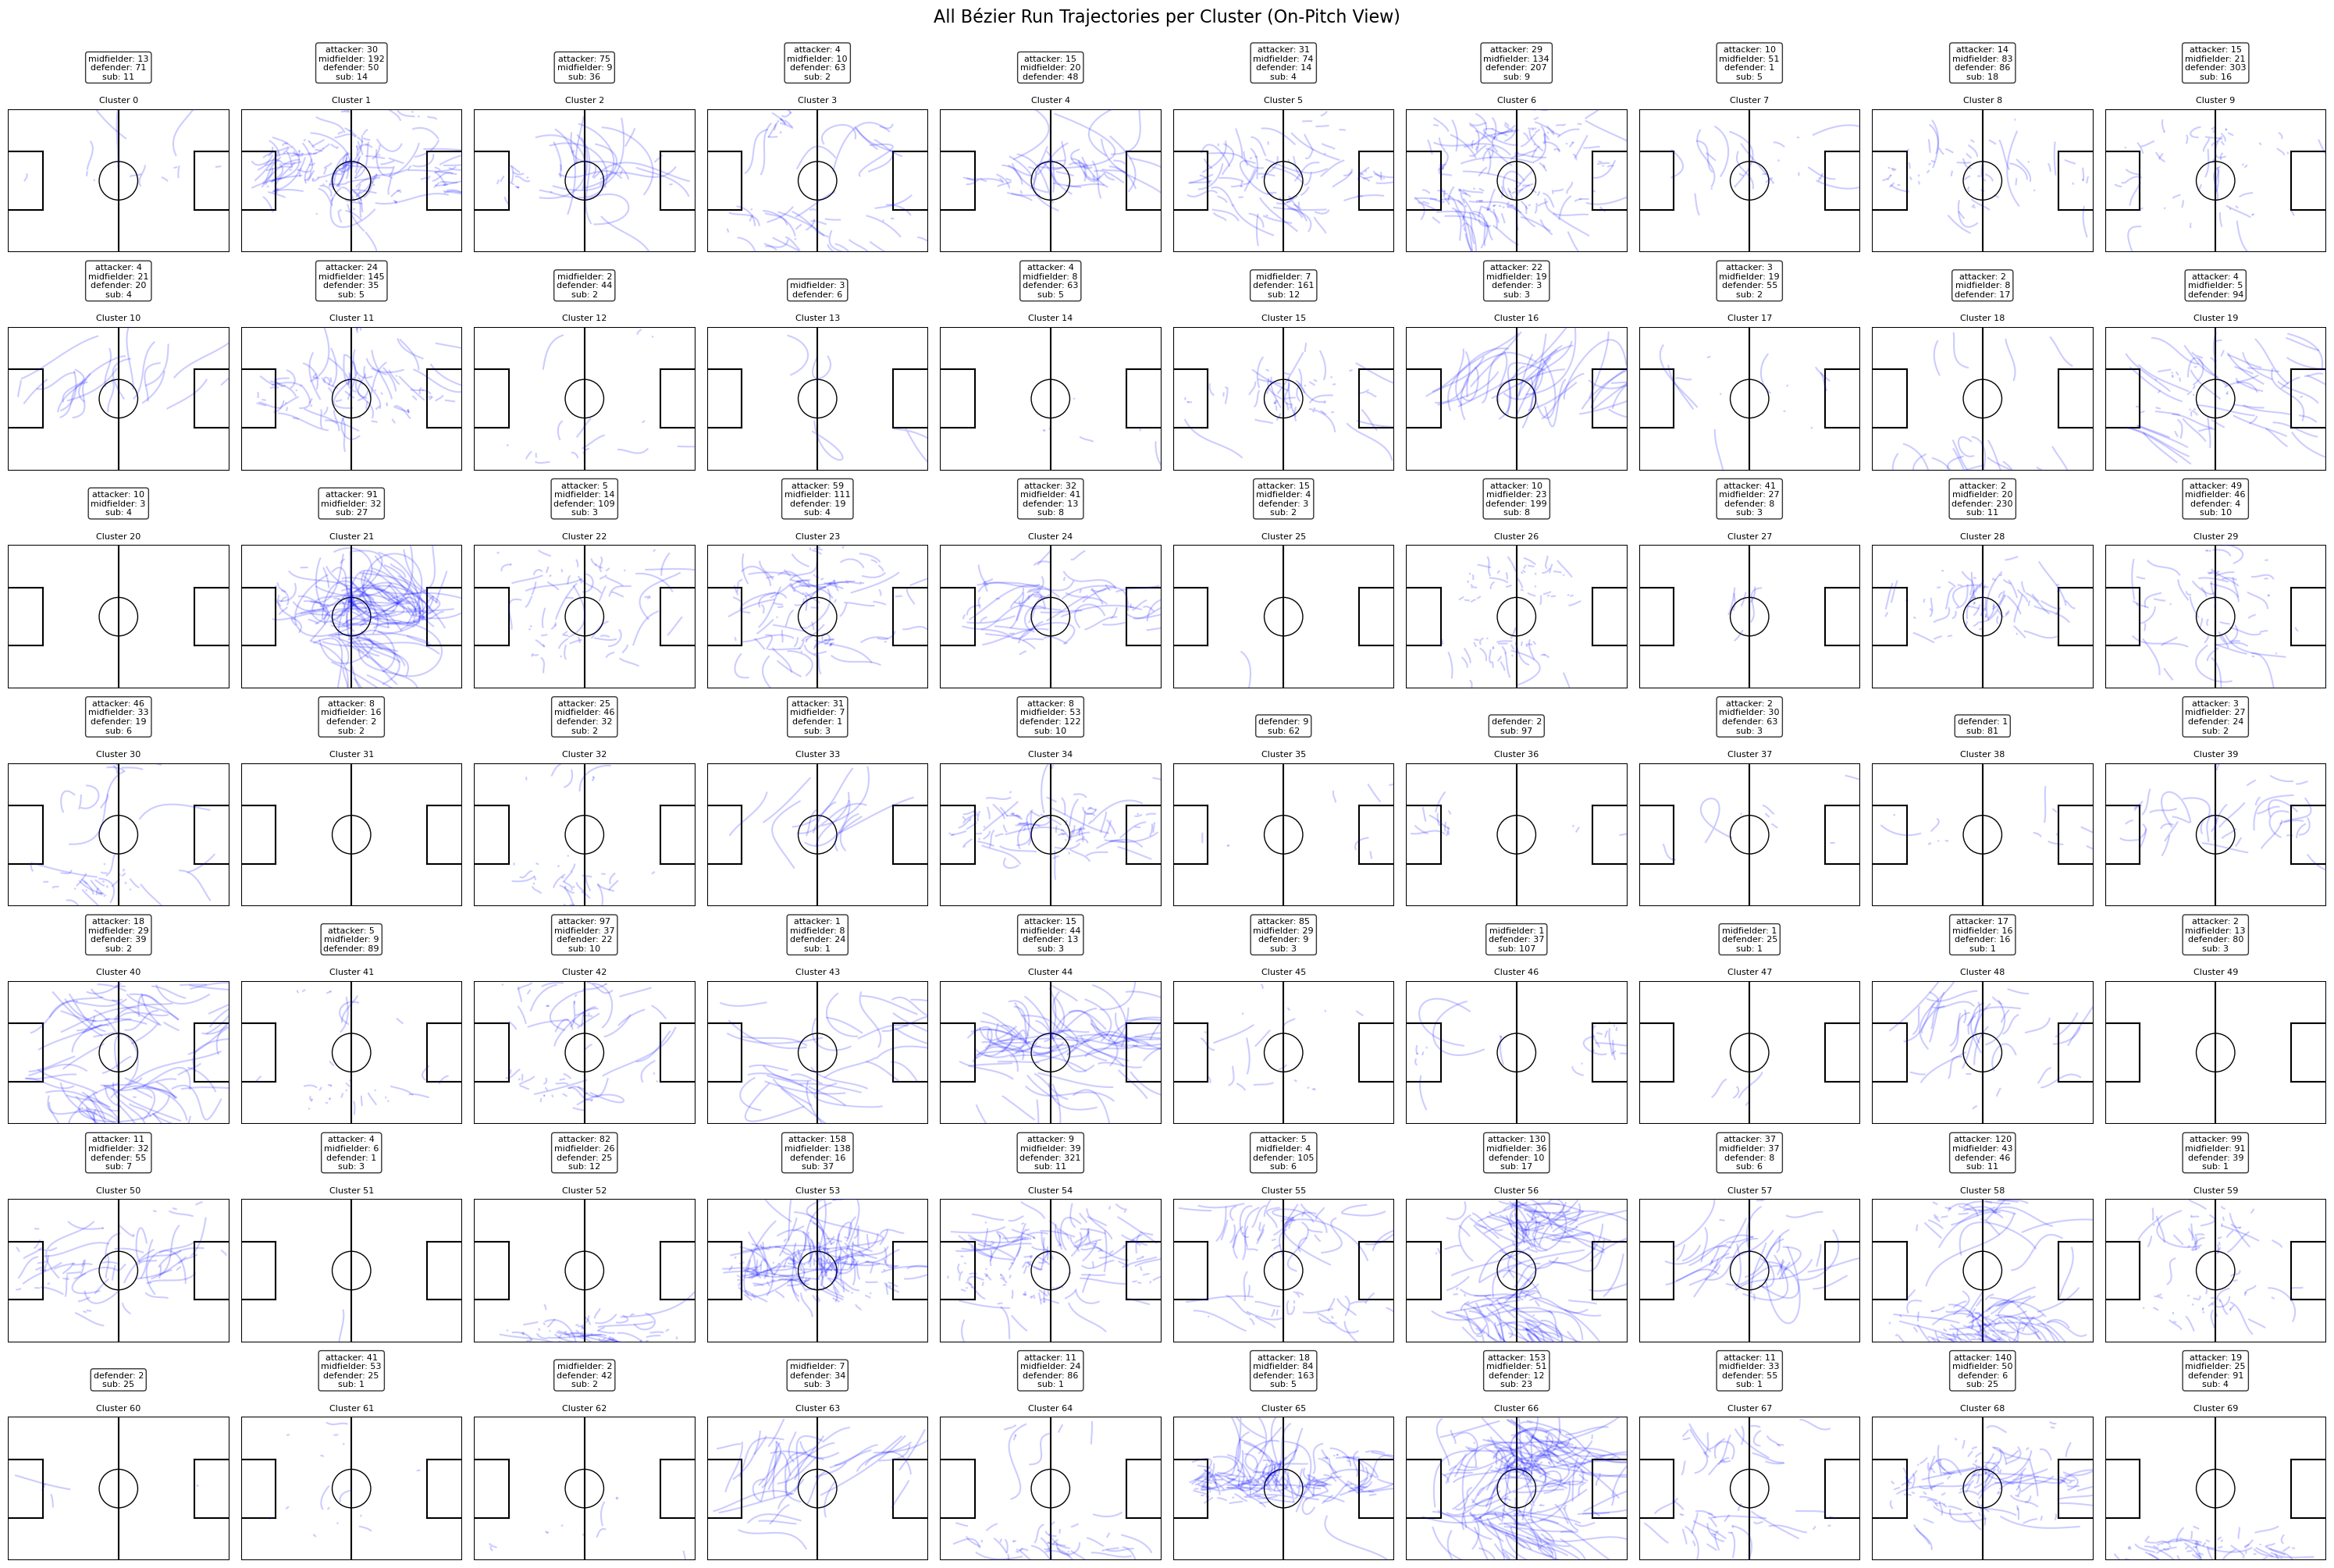

In [28]:
plot_all_cluster_trajectories_on_pitch(
    final_runs_df,
    assignments_zones,
    cluster_control_points,
    bucket_pivot=bucket_pivot,
    num_control_points=4,
    max_runs_per_cluster=200,
    plot_absolute_positions=True,
    start_zones=None,
    end_zones=None,  # You can specify zones like [1, 2, 3] if you want to filter
    phases_of_play=None,
    positions=None,
    use_absolute_zones=True, # True or False are options
    start_zones_absolute=None,
    end_zones_absolute=None,
    run_angle_range=None,  # Example: filter for runs with angles between 0 and 180 degrees
    run_forward=True,
    run_length_range = None,  # Example: filter for runs with length between 0 and 100 meters
    mean_speed_range = None,  # Example: filter for runs with mean speed between 0 and 8 m/s
    max_speed_range = None     
)